# Unsupervised Learning

In this task, we will look at how data dimensionality reduction and clustering methods work. At the same time, we'll practice solving classification task again.

We will work with the [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. Download the data [here](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). The data comes from accelerometers and gyros of Samsung Galaxy S3 mobile phones ( you can find more info about the features using the link above), the type of activity of a person with a phone in his/her pocket is also known – whether he/she walked, stood, lay, sat or walked up or down the stairs.

First, we pretend that the type of activity is unknown to us, and we will try to cluster people purely on the basis of available features. Then we solve the problem of determining the type of physical activity as a classification problem.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 17
plt.rcParams['figure.figsize'] = (12,9)

In [2]:
X_train = np.loadtxt('../Data/samsung_HAR/samsung_train.txt')
y_train = np.loadtxt('../Data/samsung_HAR/samsung_train_labels.txt')

X_test = np.loadtxt('../Data/samsung_HAR/samsung_test.txt',)
y_test = np.loadtxt('../Data/samsung_HAR/samsung_test_labels.txt')

In [3]:
# Verify dimensions
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

For clustering, we'll work with the combination of training and test samples. Merge X_train with X_test, and y_train with y_test.


In [4]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test]) #use hstack for 1D array

Define the number of unique values of the labels of the target class.

In [5]:
np.unique(y)

array([1., 2., 3., 4., 5., 6.])

In [6]:
n_classes = np.unique(y).size
n_classes

6

[These labels correspond to:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 – walking
- 2 – walking upstairs
- 3 – walking downstairs
- 4 – sitting
- 5 – standing
- 6 – laying down

Scale the sample using StandardScaler with default parameters.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the original (scaled) data. Use the scaled dataset and fix random_state (RANDOM_STATE constant).

In [8]:
pca = PCA(n_components = 0.9, random_state = RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

**Question**:
What is the minimum number of principal components required to cover the 90% of the variance of the original (scaled) data?

In [9]:
X_pca.shape[1]    # 65 principal (uncorrelated) components

65

**Question:**
What percentage of the variance is covered by the first principal component? Round to the nearest percent.

In [10]:
pca.explained_variance_ratio_[0]    # 51 %

0.5073822103501331

Visualize data in projection on the first two principal components.

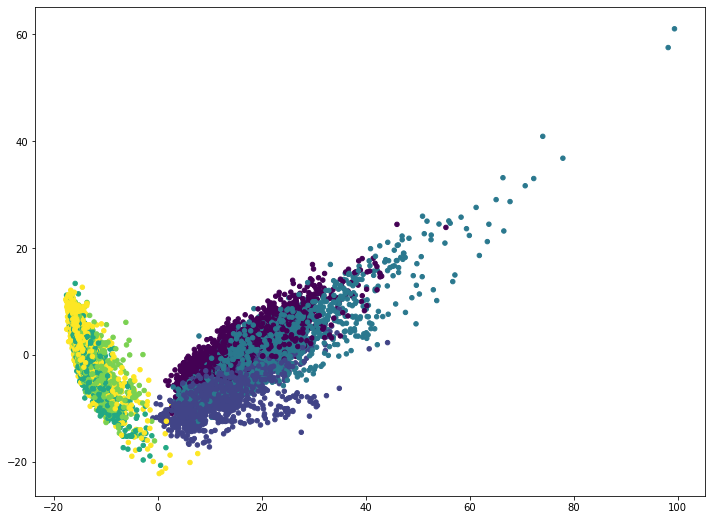

In [11]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, s = 20)

## KMeans

Perform clustering with the KMeans method, training the model on data with reduced dimensionality (by PCA). In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be looking for.

Options:

n_clusters = n_classes (number of unique labels of the target class)
n_init = 100
random_state = RANDOM_STATE (for reproducibility of the result)
Other parameters should have default values.

In [12]:
kmeans = KMeans(n_clusters = n_classes, n_init = 100, random_state = RANDOM_STATE).fit(X_pca)

In [14]:
kmeans.labels_

array([5, 5, 5, ..., 1, 1, 1], dtype=int32)

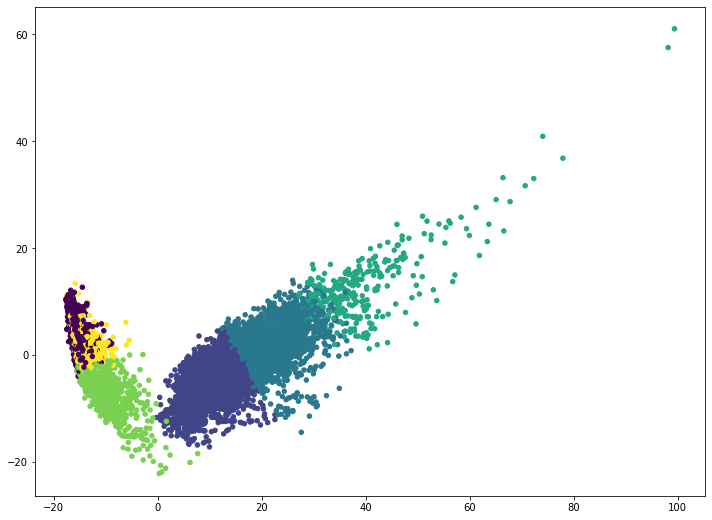

In [13]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = kmeans.labels_, s = 20)

Look at the correspondence between the cluster marks and the original class labels and what kinds of activities the KMeans algorithm is confused at.

In [15]:
contingency_table = pd.crosstab(index = y, columns = kmeans.labels_, margins=1)
contingency_table.index = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', \
                           'laying down', 'all']
contingency_table_columns = ['cluster' + str(i) for i in range(1, 7)] + ['all']
contingency_table

col_0,0,1,2,3,4,5,All
walking,0,904,740,78,0,0,1722
walking upstairs,0,1242,295,5,2,0,1544
walking downstairs,0,320,890,196,0,0,1406
sitting,91,1,0,0,450,1235,1777
standing,0,0,0,0,562,1344,1906
laying down,1558,5,0,0,329,52,1944
all,1649,2472,1925,279,1343,2631,10299


We see that for each class (i.e., each activity) there are several clusters. Let's look at the maximum percentage of objects in a class that are assigned to a single cluster. This will be a simple metric that characterizes how easily the class is separated from others when clustering.

**Question:**
Which activity is separated from the rest better than others based on the simple metric described above?

In [24]:
contingency_table.iloc[:-1, :-1].max(axis=1)

walking                904
walking upstairs      1242
walking downstairs     890
sitting               1235
standing              1344
laying down           1558
dtype: int64

In [22]:
contingency_table.iloc[:-1,-1]

walking               1722
walking upstairs      1544
walking downstairs    1406
sitting               1777
standing              1906
laying down           1944
Name: All, dtype: int64

In [29]:
pd.Series(contingency_table.iloc[:-1, :-1].max(axis=1)/contingency_table.iloc[:-1, -1],
          index=contingency_table.index[:-1])

walking               0.524971
walking upstairs      0.804404
walking downstairs    0.633001
sitting               0.694992
standing              0.705142
laying down           0.801440
dtype: float64

It can be seen that kMeans does not distinguish activities very well. Use the elbow method to select the optimal number of clusters. Parameters of the algorithm and the data we use are the same as before, we change only n_clusters.

In [35]:
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init = 100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))


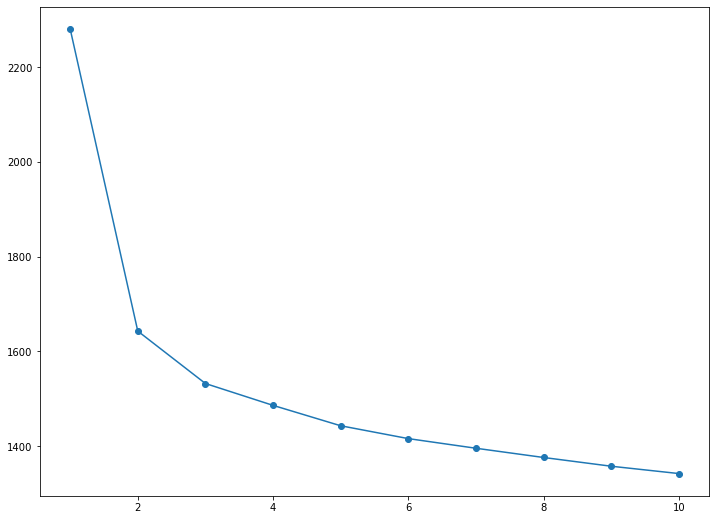

In [36]:
plt.plot(range(1, 11), inertia, marker='o')

According to the elbow method, we should chose 2 clusters.

## Agglomerative Clustering

In [38]:
ag = AgglomerativeClustering(n_clusters = n_classes,
                             linkage = 'ward').fit(X_pca)

Calculate the Adjusted Rand Index (sklearn.metrics) for the resulting clustering and for KMeans with 6 clusters.

In [39]:
kmeans = KMeans(n_clusters=n_classes, n_init = 100, random_state=RANDOM_STATE).fit(X_pca)

In [40]:
print(f'KMeans: ARI = %.3f' % metrics.adjusted_rand_score(y, kmeans.labels_))
print(f'Agglomerative Clustering: ARI = %.3f' % metrics.adjusted_rand_score(y, ag.labels_))

KMeans: ARI = 0.420
Agglomerative Clustering: ARI = 0.494


* According to ARI, KMeans handled clustering worse than Agglomerative Clustering.
* For ARI, it does not matter which tags are assigned to the cluster, only the partitioning of instances into clusters matters 
* In case of random partitioning into clusters, ARI will be close to zero

This problem cannot be solved well as a clustering problem. Now, let's solve it as a classification problem using support vector machine.

## Classification - Support Vector Machine (SVM)

Choose the C hyperparameter for LinearSVC using GridSearchCV.

Train the new StandardScaler on the training set (with all original features), apply scaling to the test set
In GridSearchCV, specify cv = 3.

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
svc = LinearSVC(random_state = RANDOM_STATE)
svc_params = {'C': [ 0.001, 0.01, 0.1, 1, 10]}

In [6]:
%%time
best_svc = GridSearchCV(svc, svc_params, n_jobs=-1, cv=3)
best_svc.fit(X_train_scaled, y_train)

CPU times: user 4.82 s, sys: 137 ms, total: 4.95 s
Wall time: 16.3 s


/Users/tongxu/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [7]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382506099134881)

0.1 is the best value for hyperparameter C based on the cross validation score.

In [8]:
y_predicted = best_svc.predict(X_test_scaled)

In [9]:
tab = pd.crosstab(index=y_test, columns=y_predicted, margins=True)
tab.index = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', \
            'laying down', 'all']
tab.columns = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', \
            'laying down', 'all']
tab

,walking,walking upstairs,walking downstairs,sitting,standing,laying down,all
walking,494,2,0,0,0,0,496
walking upstairs,12,459,0,0,0,0,471
walking downstairs,2,3,414,1,0,0,420
sitting,0,4,0,426,61,0,491
standing,0,0,0,15,517,0,532
laying down,0,0,0,0,11,526,537
all,508,468,414,442,589,526,2947


In [10]:
tp = []
fp = []
fn = []

for i in range(6):
    tp.append(tab.iloc[i,i])
    fp.append(tab.iloc[-1,i] - tab.iloc[i,i])
    fn.append(tab.iloc[i,-1] - tab.iloc[i,i])
    
tp = np.array(tp)
fp = np.array(fp)  
fn = np.array(fn)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
pd.DataFrame({'precision': precision, 'recall': recall}, index = tab.index[:-1])

,precision,recall
walking,0.972441,0.995968
walking upstairs,0.980769,0.974522
walking downstairs,1.000000,0.985714
sitting,0.963801,0.867617
standing,0.877759,0.971805
laying down,1.000000,0.979516


In [15]:
print(metrics.classification_report(y_test, y_predicted, target_names=tab.index[:-1]))

                    precision    recall  f1-score   support

           walking       0.97      1.00      0.98       496
  walking upstairs       0.98      0.97      0.98       471
walking downstairs       1.00      0.99      0.99       420
           sitting       0.96      0.87      0.91       491
          standing       0.88      0.97      0.92       532
       laying down       1.00      0.98      0.99       537

          accuracy                           0.96      2947
         macro avg       0.97      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



SVC performed worst on standing based on precision and recall scores.

Redo SVM classification with PCA.

In [71]:
pca = PCA(n_components = 0.9, random_state = RANDOM_STATE).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

In [73]:
%%time
best_svc.fit(X_train_pca, y_train)

CPU times: user 1.19 s, sys: 11.6 ms, total: 1.2 s
Wall time: 4.4 s


/Users/tongxu/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [74]:
best_svc.best_params_, best_svc.best_score_

({'C': 1}, 0.8998943094169531)

The result with PCA is worse by 4%, based on cross validation scores.

* Principal component analysis reduce the computational complexity of and therefore the model training time 
* PCA can be used to visualize data by projecting the data onto 1D, 2D, or 3D space. However, for multidimensional data visualization it is better to use manifold learning methods (i.e. tSNE)